# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo - notebook v6</h1>

<p style="text-align: center;">Alex Dowling<sup>a</sup>, Jacob P. Krell<sup>b</sup>, David S. Mebane<sup>b</sup>

<p style="text-align: center;"><sup>a</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>b</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

## Method

- fit GP to raw data as a smoothing function
- take derivative of smoothed data, which is possible via chain rule of GP analytic gradient
- fit GP to derivative, which is the "GP Model" of TCLab
- integrate GP to validate model of derivative

## Change Log
- This files is derived from `pyomo_tclab_v5.ipynb`
- Removed lag for control signal `Q` to simplify first Pyomo implementation.

## Setup

In [1]:
import os
dir = os.path.abspath('')  # directory of notebook
import pandas as pd
import numpy as np
from FoKL import FoKLRoutines
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Load and parse data:

In [2]:
filename = "tclab_sine_test.csv"
data = pd.read_csv(os.path.join(dir, filename))

tvec = data["Time"].values
Q1 = data["Q1"].values
TS1 = data["T1"].values

Define heater power control signal:

In [3]:
Q1f = interp1d(tvec, Q1, kind='previous')  # piecewise Q1
dQ1f_analytic = lambda t: 1500 * np.cos(30 * np.pi * t / tvec[-1]) * np.pi / tvec[-1]  # derivative of analytic Q1
dQ1f = interp1d(tvec, dQ1f_analytic(tvec), kind='previous')  # piecewise derivative of analytic Q1

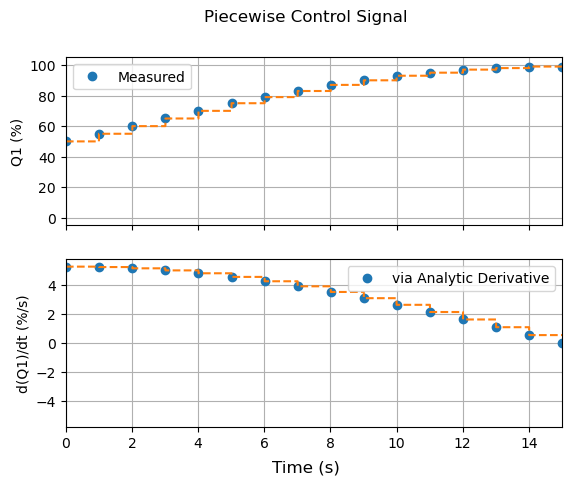

In [4]:
tvec_ub = tvec[1::] - 1e-3  # upper bounds for piecewise plots
tvec_piecewise = [tvec[0]]
for i in range(len(tvec_ub)):
    tvec_piecewise += [tvec_ub[i], tvec[i + 1]]
tvec_piecewise = np.array(tvec_piecewise)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.suptitle("Piecewise Control Signal")
fig.supxlabel("Time (s)")

axs[0].plot(tvec, Q1, 'o')
axs[0].plot(tvec_piecewise, Q1f(tvec_piecewise), '--')
axs[0].set_ylabel("Q1 (%)")
axs[0].set_xlim([0, tvec[-1] / 15 / 4])
axs[0].legend(["Measured"])
axs[0].grid()

axs[1].plot(tvec, dQ1f_analytic(tvec), 'o')
axs[1].plot(tvec_piecewise, dQ1f(tvec_piecewise), '--')
axs[1].set_ylabel("d(Q1)/dt (%/s)")
axs[1].set_xlim([0, tvec[-1] / 15 / 4])
axs[1].legend(["via Analytic Derivative"])
axs[1].grid()

## Benchmark

Predicting temperatures via the two-state ODE,

In [5]:
alpha = 0.00016                                                                     # watts / (units P1 * percent U1)
P1 = 200                                                                            # P1 units
T_amb = TS1[0]  # ambient temperature

IC = [T_amb, T_amb]  # initial condition of states [TH1, TS1]
CpH =  7.006         # J/degC
CpS = 0.01           # J/degC
Ua =  0.051          # W/degC
Ub =  0.001          # W/degC

In [6]:
def dy_benchmark(t, y):
    """Benchmark ODE, for TS1."""
    TH1, TS1 = y
    dTH1 = (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1f(t)) / CpH
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

soln_benchmark = solve_ivp(dy_benchmark, [tvec[0], tvec[-1]], IC, t_eval=tvec)

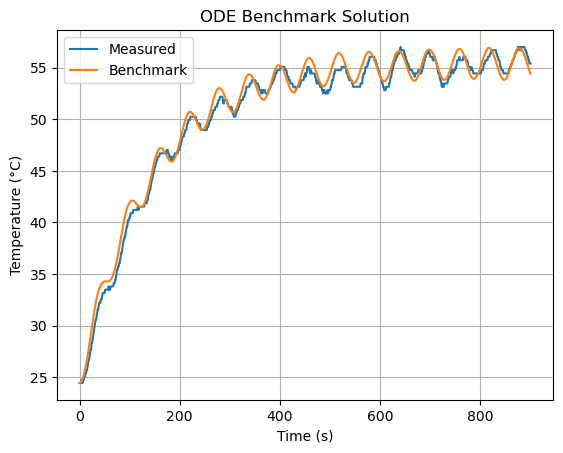

In [7]:
TS1_benchmark = soln_benchmark.y[1]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_benchmark)
plt.grid()
plt.title('ODE Benchmark Solution')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Benchmark'])

## Derivative of Smoothed Data

Since raw measurements are noisy, a smoothing functions is applied before calculating the time derivative.

### Smoothing

Using a GP as the smoothing function,

In [8]:
GP_T = FoKLRoutines.FoKL(kernel=1, UserWarnings=False)
_ = GP_T.fit([tvec, Q1], TS1, clean=True)

[1, 3592.1272475128376]
[2, 3587.245251431803]
[2, 2325.6195698812176]
[3, 2307.576809156444]
[3, 574.1060402705103]
[4, 574.1060402705103]
[4, 540.913851438417]
[4, -331.6235740865496]
[5, -331.6235740865496]
[5, -331.6235740865496]
[5, -384.52968105955193]
[6, -384.52968105955193]
[6, -384.52968105955193]
[6, -391.22681724247286]
[6, -394.68886203696707]
[7, -394.68886203696707]
[7, -394.68886203696707]
[7, -390.73500263956157]


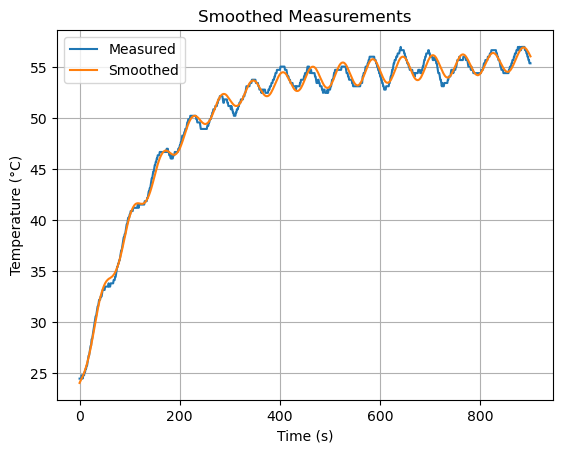

In [9]:
TS1_smooth = GP_T.evaluate()

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1)
plt.plot(tvec, TS1_smooth)
plt.grid()
plt.title('Smoothed Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Measured', 'Smoothed'])

### Derivative

Applying the chain rule to obtain training data,

In [10]:
dGP = GP_T.bss_derivatives()  # gradient of GP_T

dGPdt = interp1d(tvec, dGP[:, 0])
dGPdQ1 = interp1d(Q1, dGP[:, 1])
dTS1f = lambda t: dGPdt(t) + dGPdQ1(Q1f(t)) * dQ1f(t)  # interpolation function

dTS1 = dTS1f(tvec)  # evaluate interpolation function at tvec to form training data

Validating training data:

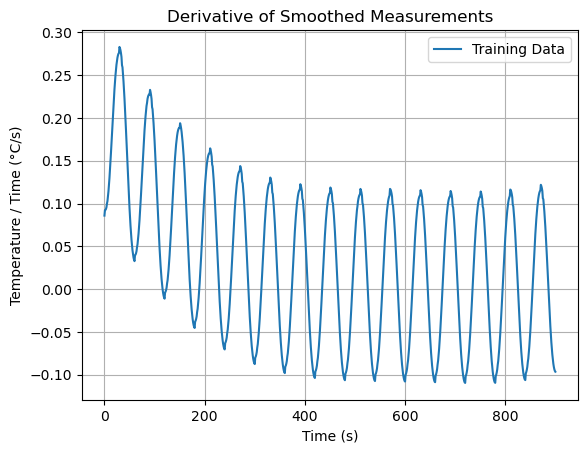

In [11]:
%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1)
plt.title('Derivative of Smoothed Measurements')
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data'])
plt.grid()

In [12]:
def dy_training(t, y):
    """ODE to integrate GP's training data'."""
    return [dTS1f(t)]

soln_training = solve_ivp(dy_training, [tvec[0], tvec[-1]], [TS1_smooth[0]], t_eval=tvec)

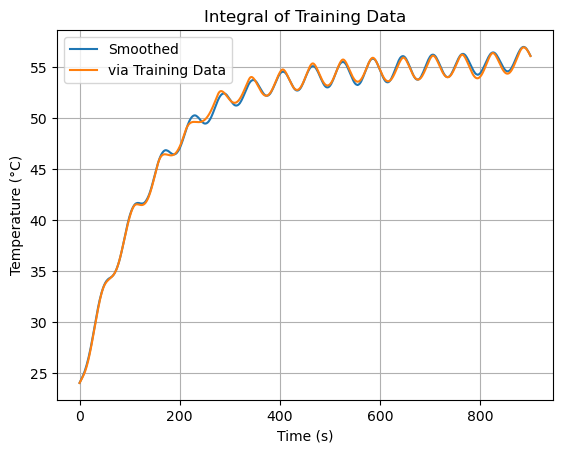

In [13]:
TS1_training = soln_training.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.grid()
plt.title('Integral of Training Data')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
_ = plt.legend(['Smoothed', 'via Training Data'])

## GP Model of Derivative

### Training with no lag

In [14]:
GP_dT = FoKLRoutines.FoKL(kernel=1, UserWarnings=False, aic=True)
print("Training with no lag:")
GP_dT.fit([TS1, Q1], dTS1, clean=True)

Training with no lag:
[1, -3635.839042798567]
[2, -3634.275707722665]
[2, -3633.0162943844007]
[3, -3630.4172534309346]


(array([[ 0.10582258, -0.00486814, -0.21667144],
        [ 0.10315897, -0.0100149 , -0.21103671],
        [ 0.09171641, -0.01306437, -0.18119903],
        ...,
        [ 0.10024544,  0.00195313, -0.19365833],
        [ 0.08804453, -0.01893959, -0.1900078 ],
        [ 0.09678366, -0.00286247, -0.20048778]]),
 array([[0., 1.],
        [1., 0.]]),
 array([-3635.8390428 , -3634.27570772, -3633.01629438, -3630.41725343]))

In [15]:
dTS1_GP = GP_dT.evaluate()

Plot results with no lag

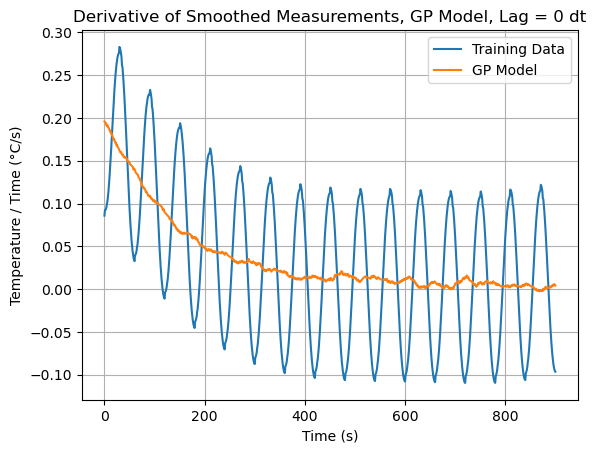

In [16]:
%matplotlib inline
plt.figure()
plt.plot(tvec, dTS1)
plt.plot(tvec, dTS1_GP)
plt.title(f"Derivative of Smoothed Measurements, GP Model, Lag = {0} dt")
plt.xlabel('Time (s)')
plt.ylabel('Temperature / Time (°C/s)')
plt.legend(['Training Data', 'GP Model'])
plt.grid()

### Integration

In [17]:
def dy_GP(t, y):
    """ODE to integrate GP of derivative."""
    # Debuging attempt: removed SingleInstance=True
    return [GP_dT.evaluate([y[0], Q1f(t)], clean=True)[0]]


soln_GP = solve_ivp(
    fun=dy_GP, 
    t_span=[tvec[0], tvec[-1]], 
    y0 = [TS1_smooth[0]], 
    method='LSODA', 
    t_eval=tvec)

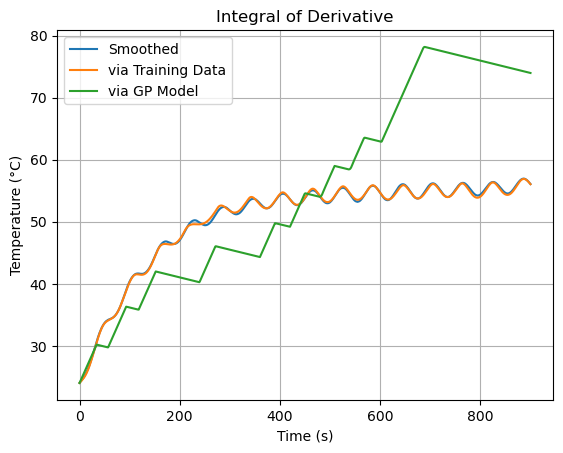

In [18]:
TS1_dGP = soln_GP.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.plot(tvec, TS1_dGP)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via Training Data', 'via GP Model'])
plt.grid()

Repeat, but with fixed time step (actually max timestep):

In [19]:
soln_GP_fixed_dt = solve_ivp(
    fun=dy_GP, 
    t_span= [tvec[0], tvec[-1]], 
    y0=[TS1_smooth[0]], 
    method='LSODA', 
    t_eval=tvec, 
    max_step=1)

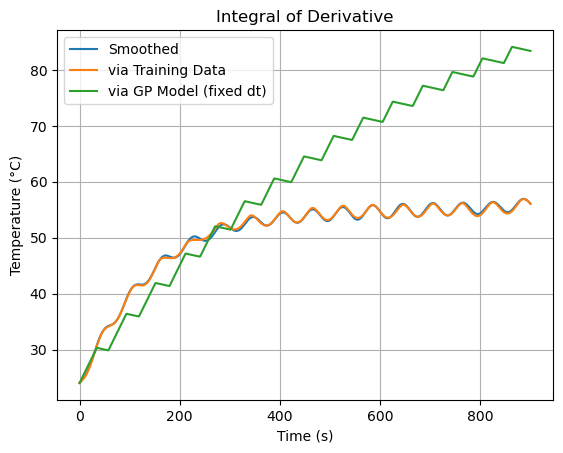

In [20]:
TS1_dGP_fixed_dt = soln_GP_fixed_dt.y[0]

%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.plot(tvec, TS1_dGP_fixed_dt)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via Training Data', 'via GP Model (fixed dt)'])
plt.grid()

Numerically integrate with forward Euler. This is close to the method we will use with Pyomo:

In [21]:
# Initialize vector to store forward Euler solution
soln_GP_forward_euler = np.zeros(len(TS1_smooth))

# Initialize vector to store GP evaluations
dTS1_GP = np.zeros(len(TS1_smooth)-1)

# Initial condition
soln_GP_forward_euler[0] = TS1_smooth[0]

# Forward Euler integration
# Loop over all of the time points except the last one
for i, t in enumerate(tvec[:-1]):

    # Calculate time step
    dt = tvec[i + 1] - tvec[i]

    # Evaluate GP model at current time
    dTS1_GP[i] = GP_dT.evaluate([soln_GP_forward_euler[i], Q1f(t)], clean=True)[0]

    # Take the forward Euler step
    soln_GP_forward_euler[i+1] = soln_GP_forward_euler[i] + dTS1_GP[i] * dt

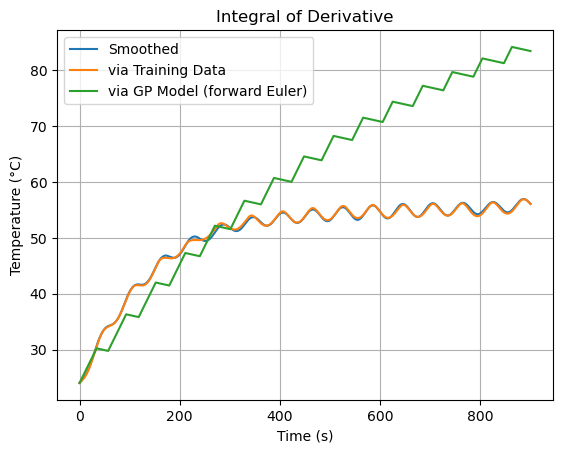

In [22]:
%matplotlib inline
plt.figure()
plt.plot(tvec, TS1_smooth)
plt.plot(tvec, TS1_training)
plt.plot(tvec, soln_GP_forward_euler)
plt.title('Integral of Derivative')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend(['Smoothed', 'via Training Data', 'via GP Model (forward Euler)'])
plt.grid()